### 2.3.1. Загрузка данных и первичный анализ

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [38]:
data = pd.read_csv('S05-hw-dataset.csv')

print(data.head()) # первые строки датасета
print(data.info()) # информацию о столбцах и типах
print(data.describe()) # базовые описательные статистики
print(data["default"].value_counts(normalize=True)) # распределение целевого признака

print("Объектов в датасете:", data.shape[0])
print("Признаков в датасете:", data.shape[1])



   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052   
1         

- Объектов в датасете: 3000
- Признаков в датасете: 17
- Аномалий нет.
- Таргет распределён относительно равномерно.



### 2.3.2. Подготовка признаков и таргета

In [39]:
y = data["default"]
X = data.drop(columns=["client_id", "default"])

print("Проверка, что все используемые признаки числовые:", len(X.select_dtypes(exclude="number").columns) == 0)
print("проверка диапазона", X["debt_to_income"].between(0, 1).all())

Проверка, что все используемые признаки числовые: True
проверка диапазона True


### 2.3.3. Train/Test-сплит и бейзлайн-модель

In [40]:
# Разделить данные на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Построить бейзлайн-модель на основе DummyClassifier:
dc = DummyClassifier(strategy="stratified")
dc.fit(x_train, y_train)

y_pred = dc.predict(x_test)

dc_acc = accuracy_score(y_test, y_pred)
print("Accuracy:", dc_acc)

y_proba = dc.predict_proba(x_test)[:, 1]
dc_roc = roc_auc_score(y_test, y_proba)
dc_p = precision_score(y_test, y_pred, zero_division=0)
dc_r = recall_score(y_test, y_pred, zero_division=0)
dc_f1 = f1_score(y_test, y_pred, zero_division=0)
print("ROC-AUC:", dc_roc)

Accuracy: 0.5066666666666667
ROC-AUC: 0.4673418768085986


Бейзлайн нужен как точка отсчёта, чтобы понять, действительно ли более сложная модель дает улучшение

### 2.3.4. Логистическая регрессия и подбор гиперпараметров

In [41]:
# Построить Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

# Подобрать параметр регуляризации C

param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(x_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (по CV):", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры: {'logreg__C': 100.0}
Лучший ROC-AUC (по CV): 0.8606625890118563


Для лучшей найденной модели посчитать на тестовой выборке:

- accuracy;
- ROC-AUC;
- по желанию: precision, recall, f1, confusion matrix.

In [42]:
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(x_test)
y_test_proba = best_model.predict_proba(x_test)[:, 1]

l_acc = accuracy_score(y_test, y_test_pred)
l_roc = roc_auc_score(y_test, y_test_proba)
l_f1 = f1_score(y_test, y_test_pred, zero_division=0)
l_pc = precision_score(y_test, y_test_pred, zero_division=0)
l_rc = recall_score(y_test, y_test_pred, zero_division=0)

print("Accuracy:", l_acc)
print("ROC-AUC:", l_roc)
print("Precision:", l_pc)
print("Recall:", l_rc)
print("F1-score:", l_f1)
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

Accuracy: 0.8016666666666666
ROC-AUC: 0.87564879886087
Precision: 0.7953488372093023
Recall: 0.6951219512195121
F1-score: 0.7418655097613883
Confusion matrix:
 [[310  44]
 [ 75 171]]


<Figure size 640x480 with 0 Axes>

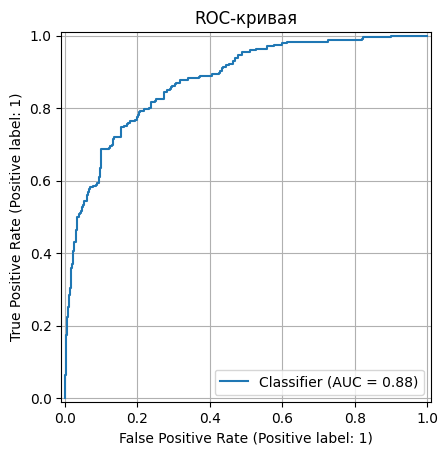

In [43]:
from sklearn.metrics import RocCurveDisplay

plt.figure()
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC-кривая")
plt.grid(True)

plt.savefig("figures/rocCurve.png", dpi=200, bbox_inches="tight")
plt.show()


### 2.3.5. Сравнение бейзлайна и логистической регрессии, текстовые выводы

In [44]:
results = pd.DataFrame([
    {
        "model": "DummyClassifier",
        "accuracy": dc_acc,
        "roc_auc": dc_roc,
        "precision": dc_p,
        "recall": dc_r,
        "f1": dc_f1,
    },
    {
        "model": "LogisticRegression",
        "accuracy": l_acc,
        "roc_auc": l_roc,
        "precision": l_pc,
        "recall": l_rc,
        "f1": l_f1,
    },
]).round(4)

print(results)

# насколько выросло
print("Разница:")
print("accuracy:", round(l_acc - dc_acc, 4))
print("roc_auc:", round(l_roc - dc_roc, 4))
print("precision:", round(l_pc - dc_p, 4))
print("recall:", round(l_rc - dc_r, 4))
print("f1:", round(l_f1 - dc_f1, 4))

                model  accuracy  roc_auc  precision  recall      f1
0     DummyClassifier    0.5067   0.4673     0.4038  0.4268  0.4150
1  LogisticRegression    0.8017   0.8756     0.7953  0.6951  0.7419
Разница:
accuracy: 0.295
roc_auc: 0.4083
precision: 0.3915
recall: 0.2683
f1: 0.3268


### Сравнение с другой моделью

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 10],
}

rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

rf_grid.fit(x_train, y_train)

rf_best = rf_grid.best_estimator_

rf_pred = rf_best.predict(x_test)
rf_proba = rf_best.predict_proba(x_test)[:, 1]

rf_acc = accuracy_score(y_test, rf_pred)
rf_roc = roc_auc_score(y_test, rf_proba)
rf_p = precision_score(y_test, rf_pred)
rf_r = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

results = pd.concat([
    results,
    pd.DataFrame([{
        "model": "RandomForest",
        "accuracy": rf_acc,
        "roc_auc": rf_roc,
        "precision": rf_p,
        "recall": rf_r,
        "f1": rf_f1,
    }])
]).round(4)

print(results)

                model  accuracy  roc_auc  precision  recall      f1
0     DummyClassifier    0.5067   0.4673     0.4038  0.4268  0.4150
1  LogisticRegression    0.8017   0.8756     0.7953  0.6951  0.7419
0        RandomForest    0.7850   0.8514     0.7940  0.6423  0.7101


- DummyClassifier не использует признаки и угадывает классы: accuracy=0.52, ROC-AUC=0.5148.
- Логистическая регрессия: accuracy=0.8017, ROC-AUC=0.8756.
- Прирост составил +0.2817 и +0.3609 соответственно. precision +0.3787, recall +0.2683, F1 +0.3202
- Итог: для этой задачи логистическая регрессия разумнее бейзлайна, потому что даёт более высокие метрики.